In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

Main Problems:
 - Very noisy data, we expect relatively low R-squared even with a perfect model
 - Large feature space means we will be prone to overfitting, feature selection & regularization will be important
 - We have several highly influential points
 
Plan:
 - Because of our skewed response variable, we should predict log(y)
 - Fit a full model to understand outliers and influential points, prune these points
 - Next, try feature selection to compare full model, mixed selection model, and PCA model
 - For each model, run diagnostics to see which meets assumptions the best, R-squared, etc.

# Section 1: Baseline Model and Identification of Influential Points

In [2]:
df = pd.read_csv('data/clean_fire_data.csv').drop(columns=['Unnamed: 0'])
df['start_date'] = pd.to_datetime(df['start_date']).astype('int64')/(10**9)
reg_df = df.drop(columns=['incident name', 'ID']) # drop columns like name of incident, ID for model fitting
response = 'size'
numerical_features = reg_df.columns.drop([response, 'fully_contained', 'geographic_area', 'weather', 'weather_description'])

In [3]:
features = reg_df.columns.drop(response) 

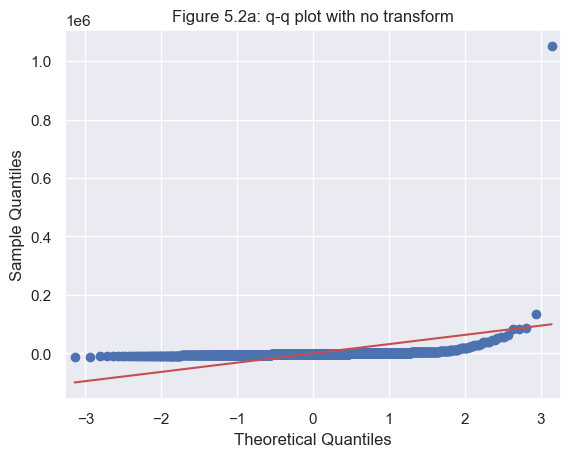

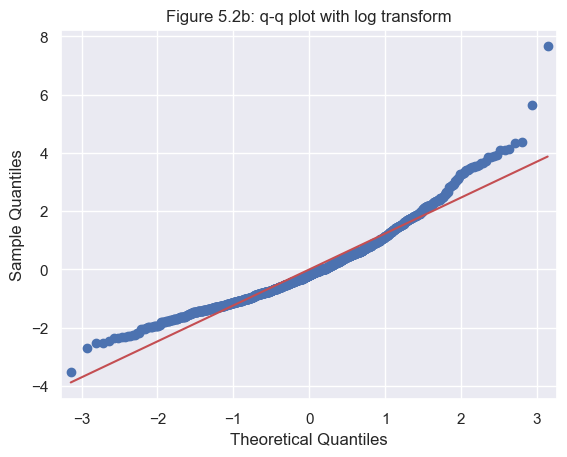

In [4]:
baseline_formula = f'{response} ~ {" + ".join(features)}'
baseline_model = smf.ols(baseline_formula, data=reg_df).fit()
sm.qqplot(baseline_model.resid, line ='s')
plt.title('Figure 5.2a: q-q plot with no transform')
plt.show()
plt.close()
baseline_formula = f'np.log({response}) ~ {" + ".join(features)}'
baseline_model = smf.ols(baseline_formula, data=reg_df).fit()
sm.qqplot(baseline_model.resid, line ='s')
plt.title('Figure 5.2b: q-q plot with log transform')
plt.show()
plt.close()

In [5]:
baseline_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.2339,8.687,1.984,0.047,0.191,34.277
fully_contained[T.True],-0.2540,0.092,-2.755,0.006,-0.435,-0.073
geographic_area[T.EACC],-0.1964,0.630,-0.312,0.755,-1.432,1.039
geographic_area[T.GBC],0.3791,0.543,0.698,0.486,-0.687,1.445
geographic_area[T.NRC],0.3589,0.482,0.744,0.457,-0.587,1.305
geographic_area[T.NWCC],0.1796,0.441,0.407,0.684,-0.686,1.046
geographic_area[T.ONCC],0.6578,0.561,1.172,0.241,-0.443,1.759
geographic_area[T.RMC],0.3519,0.584,0.603,0.547,-0.794,1.498
geographic_area[T.SAC],-0.0146,0.654,-0.022,0.982,-1.298,1.268
geographic_area[T.SWC],0.4323,0.621,0.696,0.487,-0.787,1.651


,lat,lon,start_date,fully_contained,geographic_area,size,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,rain,weather,weather_description
280,34.860000,-77.051000,1.682035e+09,False,SAC,32156.0,294.53,294.32,1021,61,286.71,0,3.60,0.00,Other,other
343,39.982000,-105.709000,1.688774e+09,False,RMC,95.0,285.17,284.18,1013,67,279.24,57,0.91,0.93,Rain,light rain
451,27.312000,-97.981000,1.691021e+09,True,SAC,3950.0,307.13,312.19,1014,52,295.88,0,6.17,0.00,Rain,light rain
502,35.192000,-115.318000,1.690502e+09,False,ONCC,93078.0,310.71,308.00,1009,12,276.50,2,4.79,0.00,Clear,clear sky
584,64.272000,-149.422000,1.690675e+09,False,ACC,58933.0,292.09,291.89,1019,71,286.72,100,2.86,0.23,Rain,light rain
606,63.929000,-146.022000,1.690589e+09,False,ACC,17414.0,297.27,296.57,1016,32,279.56,100,7.72,0.00,Other,other
607,64.076000,-146.400000,1.690243e+09,False,ACC,57395.0,301.68,302.22,1008,50,290.25,91,1.39,0.00,Clouds,overcast clouds
608,63.998000,-150.106000,1.690416e+09,False,ACC,52966.0,297.72,297.93,1016,65,290.71,55,0.67,0.00,Clouds,broken clouds
690,46.190000,-113.813000,1.689898e+09,False,NRC,6988.0,299.16,299.16,1016,53,288.85,51,1.44,1.07,Rain,moderate rain
809,41.859000,-123.834000,1.692144e+09,False,ONCC,95107.0,302.99,305.68,1015,60,294.39,49,2.04,0.00,Clouds,scattered clouds


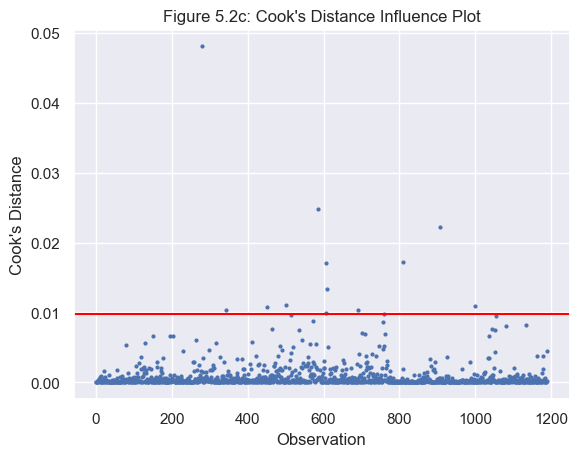

In [6]:
influence_summary = baseline_model.get_influence().summary_frame()
yval = influence_summary['cooks_d']
percentile = np.percentile(yval, 99)
xval = range(len(yval))
plt.scatter(xval, yval, s=4)
plt.axhline(percentile, color='red')
plt.xlabel('Observation')
plt.ylabel('Cook\'s Distance')
plt.title('Figure 5.2c: Cook\'s Distance Influence Plot')
display(reg_df[yval > percentile])

In [7]:
pruned_df = reg_df[yval < percentile]
pruned_model = smf.ols(baseline_formula, data=pruned_df).fit()
pruned_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(size)   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     9.275
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           6.76e-34
Time:                        20:31:28   Log-Likelihood:                -1881.1
No. Observations:                1178   AIC:                             3818.
Df Residuals:                    1150   BIC:                             3960.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  19.8180      8.442      2.348      0.019       3.256      36.381
fully_contained[T.True]                    -0.1883      0.090     -2.090      0.037      -0.365      -0.012
geographic_area[T.EACC]                     0.3745      0.620      0.604      0.546      -0.841       1.590
geographic_area[T.GBC]                      0.9164      0.536      1.710      0.088      -0.135       1.968
geographic_area[T.NRC]                      0.8540      0.478      1.788      0.074      -0.083       1.791
geographic_area[T.NWCC]                     0.7057      0.438      1.612      0.107      -0.153       1.564
geographic_area[T.ONCC]                     1.0247      0.557      1.840      0.066      -0.068       2.117
geographic_area[T.RMC]                      0.9312      0.577      1.615      0.107      -0.200       2.062
geographic_area[T.SAC]                      0.5591      0.643      0.869      0.385      -0.703       1.821
geographic_area[T.SWC]                      0.9938      0.612      1.623      0.105      -0.208       2.195
weather[T.Clouds]                           6.4013      2.672      2.396      0.017       1.159      11.644
weather[T.Other]                            3.1794      1.341      2.371      0.018       0.548       5.810
weather[T.Rain]                             3.5478      1.825      1.944      0.052      -0.033       7.129
weather_description[T.clear sky]            6.6895      2.660      2.515      0.012       1.470      11.909
weather_description[T.few clouds]           0.1535      0.267      0.575      0.565      -0.370       0.677
weather_description[T.light rain]           2.1874      0.905      2.418      0.016       0.412       3.963
weather_description[T.moderate rain]        1.3604      1.067      1.275      0.202      -0.733       3.453
weather_description[T.other]                3.1794      1.341      2.371      0.018       0.548       5.810
weather_description[T.overcast clouds]      0.1537      0.177      0.868      0.385      -0.194       0.501
weather_description[T.scattered clouds]     0.1489      0.200      0.745      0.456      -0.243       0.541
lat                                         0.0088      0.014      0.614      0.539      -0.019       0.037
lon                                        -0.0126      0.006     -2.032      0.042      -0.025      -0.000
start_date                              -1.632e-10   3.57e-09     -0.046      0.964   -7.17e-09    6.85e-09
temp                                       -0.0230      0.037     -0.630      0.529      -0.095       0.049
feels_like                                  0.0547      0.034      1.594      0.111      -0.013       0.122
pressure                                   -0.0217      0.0

Text(0.5, 1.0, 'Correlation Table for Fire & Weather Data')

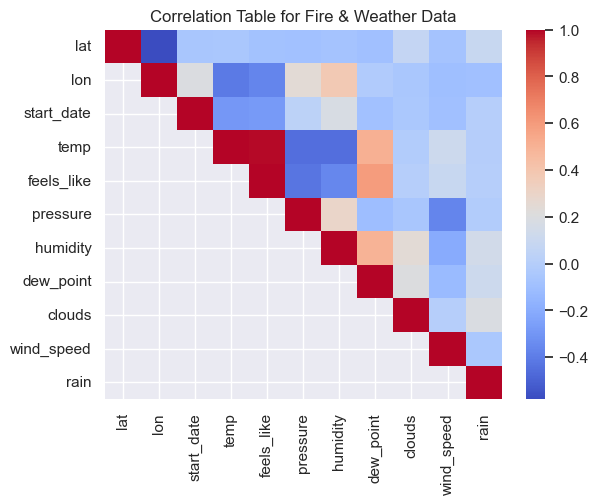

In [8]:
corr_table = reg_df[numerical_features].corr() 
sns.heatmap(corr_table, annot=False, cmap='coolwarm', mask=np.tril(corr_table, k=-1))
plt.title('Correlation Table for Fire & Weather Data')

In [9]:
non_collinear_features = reg_df.columns.drop([response, 'feels_like', 'dew_point']) 
non_collinear_formula = f'np.log({response}) ~ {" + ".join(non_collinear_features)}'
non_collinear_model = smf.ols(non_collinear_formula, data=reg_df).fit()
non_collinear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(size)   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     9.788
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           6.10e-34
Time:                        20:31:29   Log-Likelihood:                -1940.7
No. Observations:                1190   AIC:                             3933.
Df Residuals:                    1164   BIC:                             4066.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  17.8212      8.655      2.059      0.040       0.841      34.802
fully_contained[T.True]                    -0.2494      0.092     -2.715      0.007      -0.430      -0.069
geographic_area[T.EACC]                    -0.1861      0.627     -0.297      0.766      -1.415       1.043
geographic_area[T.GBC]                      0.3674      0.536      0.686      0.493      -0.683       1.418
geographic_area[T.NRC]                      0.3677      0.477      0.771      0.441      -0.568       1.303
geographic_area[T.NWCC]                     0.1645      0.435      0.378      0.706      -0.690       1.019
geographic_area[T.ONCC]                     0.6358      0.552      1.152      0.249      -0.447       1.718
geographic_area[T.RMC]                      0.3761      0.579      0.649      0.516      -0.761       1.513
geographic_area[T.SAC]                      0.0151      0.650      0.023      0.981      -1.260       1.291
geographic_area[T.SWC]                      0.4633      0.609      0.761      0.447      -0.731       1.658
weather[T.Clouds]                           5.4846      2.738      2.003      0.045       0.112      10.857
weather[T.Other]                            2.9413      1.371      2.145      0.032       0.251       5.632
weather[T.Rain]                             3.6702      1.862      1.971      0.049       0.016       7.324
weather_description[T.clear sky]            5.7250      2.728      2.098      0.036       0.372      11.078
weather_description[T.few clouds]           0.0576      0.262      0.220      0.826      -0.456       0.571
weather_description[T.light rain]           1.6310      0.924      1.765      0.078      -0.182       3.444
weather_description[T.moderate rain]        2.0392      1.061      1.921      0.055      -0.043       4.122
weather_description[T.other]                2.9413      1.371      2.145      0.032       0.251       5.632
weather_description[T.overcast clouds]      0.1903      0.177      1.074      0.283      -0.157       0.538
weather_description[T.scattered clouds]     0.1380      0.198      0.696      0.487      -0.251       0.527
lat                                         0.0064      0.014      0.443      0.658      -0.022       0.035
lon                                        -0.0115      0.006     -1.808      0.071      -0.024       0.001
start_date                              -7.263e-10   3.67e-09     -0.198      0.843   -7.93e-09    6.48e-09
temp                                        0.0108      0.006      1.777      0.076      -0.001       0.023
pressure                                   -0.0201      0.007     -2.846      0.005      -0.034      -0.006
humidity                                   -0.0026      0.0

# Attempts at Dimensionality Reduction

## PCA

### Dropping Categorical Variables

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Text(0.5, 1.0, 'Scree Plot for PCA - Categorical Features Dropped')

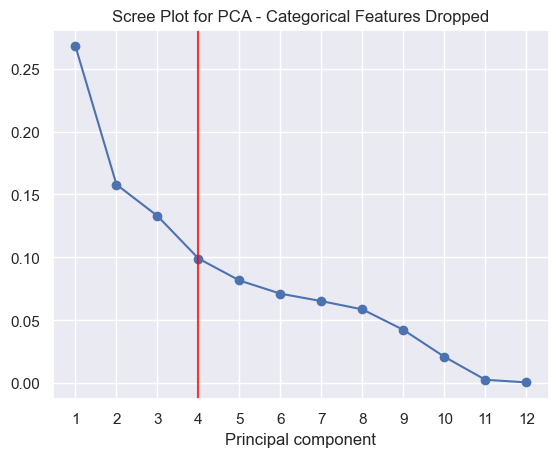

In [11]:
X = reg_df.drop(['size', 'geographic_area', 'weather', 'weather_description'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)

Z = pca.transform(X_scaled)
# scree plot
plt.plot(range(1, X_scaled.shape[1] + 1), (pca.explained_variance_ratio_), marker='o')
plt.xticks(np.arange(1, X_scaled.shape[1] + 1, 1))
plt.xlabel('Principal component')
plt.axvline(4, color=(1,0,0,0.8))
plt.title('Scree Plot for PCA - Categorical Features Dropped')

In [12]:
q = 4
pca_X = -pca.transform(X_scaled)[:,:q]
pca_df = pd.DataFrame(pca_X, columns=['Z1', 'Z2', 'Z3', 'Z4'])
pca_df[response] = df[response]
pca_df.head()

,Z1,Z2,Z3,Z4,size
0,-1.590967,-0.000784,-0.188524,1.477598,436.0
1,-1.966640,-0.930763,0.685205,0.948164,182.0
2,0.844264,1.360173,0.539251,-0.916862,695.0
3,-1.212056,-2.110484,0.782457,1.614963,475.0
4,-3.068773,0.000601,-1.348723,0.845469,888.0


In [13]:
pca_fit = smf.ols('size ~ Z1 + Z2 + Z3 + Z4', pca_df).fit()
print(pca_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4075
Date:                Sat, 08 Jun 2024   Prob (F-statistic):              0.803
Time:                        20:31:29   Log-Likelihood:                -14025.
No. Observations:                1190   AIC:                         2.806e+04
Df Residuals:                    1185   BIC:                         2.809e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3349.5439    923.248      3.628      0.0

### One-hot encoding Categorical Variables

Text(0.5, 1.0, 'Scree Plot for PCA - Categorical Features Encoded')

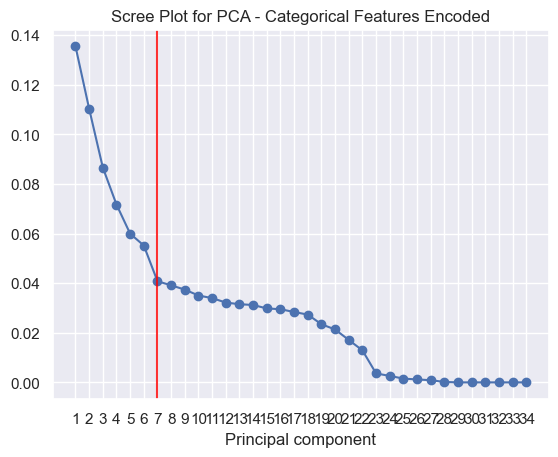

In [14]:
X_ohe = pd.get_dummies(reg_df, columns=['geographic_area', 'weather', 'weather_description'])
X_ohe_scaled = scaler.fit_transform(X_ohe)
pca_ohe = PCA()
pca_ohe.fit(X_ohe_scaled)

Z_ohe = pca_ohe.transform(X_ohe_scaled)
# scree plot
plt.plot(range(1, X_ohe_scaled.shape[1] + 1), (pca_ohe.explained_variance_ratio_), marker='o')
plt.xticks(np.arange(1, X_ohe_scaled.shape[1] + 1, 1))
plt.xlabel('Principal component')
plt.axvline(7, color=(1,0,0,0.8))
plt.title('Scree Plot for PCA - Categorical Features Encoded')

In [15]:
q = 7
pca_ohe_X = -pca_ohe.transform(X_ohe_scaled)[:,:q]
pca_ohe_df = pd.DataFrame(pca_ohe_X, columns=[f'Z{i+1}' for i in range(7)])
pca_ohe_df[response] = df[response]
pca_ohe_df.head()

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,size
0,2.530211,-0.650109,-0.494623,0.037000,0.091598,-0.765412,0.902220,436.0
1,2.691174,-1.271245,-0.369908,0.816831,-0.044943,-0.564940,0.511340,182.0
2,-1.577809,-0.878434,1.458847,-0.352435,0.192233,2.208165,-0.515048,695.0
3,2.255454,-1.036654,-0.195023,1.770572,-0.121775,-1.313074,0.670648,475.0
4,-0.465888,-3.839134,-0.018031,-1.695647,0.416270,0.542911,1.104109,888.0


In [16]:
pca_ohe_fit = smf.ols('size ~ Z1 + Z2 + Z3 + Z4 + Z5 + Z6 + Z7', pca_ohe_df).fit()
print(pca_ohe_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.393
Date:                Sat, 08 Jun 2024   Prob (F-statistic):              0.204
Time:                        20:31:30   Log-Likelihood:                -14021.
No. Observations:                1190   AIC:                         2.806e+04
Df Residuals:                    1182   BIC:                         2.810e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3349.5439    921.262      3.636      0.0

## Trying t-SNE

### Dropping categorical features

In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(n_components=3, perplexity=30)
tsne_X = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(tsne_X, columns=['T1', 'T2', 'T3'])
tsne_df[response] = df[response]
display(tsne_df.head())
tsne_fit = smf.ols('size ~ T1 + T2 + T3', tsne_df).fit()
print(tsne_fit.summary())

,T1,T2,T3,size
0,2.197146,-3.377995,-3.673908,436.0
1,1.892203,-1.876614,-1.662633,182.0
2,-3.406109,-2.643029,-11.452999,695.0
3,1.607771,-0.338011,-2.325649,475.0
4,-2.687085,-4.099977,0.502760,888.0


                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4798
Date:                Sat, 08 Jun 2024   Prob (F-statistic):              0.696
Time:                        20:31:34   Log-Likelihood:                -14025.
No. Observations:                1190   AIC:                         2.806e+04
Df Residuals:                    1186   BIC:                         2.808e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3367.7236    924.827      3.641      0.0

### One-hot encoding categorical variables

In [19]:
tsne_ohe = TSNE(n_components=3, perplexity=30)
tsne_ohe_X = tsne.fit_transform(X_ohe_scaled)
tsne_ohe_df = pd.DataFrame(tsne_ohe_X, columns=['T1', 'T2', 'T3'])
tsne_ohe_df[response] = df[response]
display(tsne_ohe_df.head())
tsne_ohe_fit = smf.ols('size ~ T1 + T2 + T3', tsne_ohe_df).fit()
print(tsne_ohe_fit.summary())

,T1,T2,T3,size
0,-11.256619,-4.964329,3.108227,436.0
1,-11.437740,-5.357141,6.456775,182.0
2,7.454431,8.729589,-5.393265,695.0
3,-10.724407,-4.148145,6.525925,475.0
4,8.638858,9.450358,-2.402267,888.0


                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1780
Date:                Sat, 08 Jun 2024   Prob (F-statistic):              0.911
Time:                        20:31:37   Log-Likelihood:                -14025.
No. Observations:                1190   AIC:                         2.806e+04
Df Residuals:                    1186   BIC:                         2.808e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3355.7633    923.762      3.633      0.0